# A little experiment with PCA

Principal Component Analysis (PCA) is a well known technique for dimensionality reduction. In simple terms, it consists in the construction of a change of basis transformation such that the vectors in the new basis correspond to directions of maximum variance in the data set, and are in decreasing order in terms of variance.

#### Goal

Suppose we are in the setting of a regression problem, i.e., our goal is to predict a continuously ranging variable, such as the canonical housing prices example. Furthermore, suppose we have a certain (large) number of numerical features that are relevant to use in our model (if there are just a few numerical features, maybe PCA is not necessary).

We want to understand what is the outcome if we fit our PCA instance with the target variable (which is, in this case, numerical) in the data set. Can this introduce data leakage in our model?

To test this, we'll construct a supervised learning problem and proceed with 2 versions of the model:

1. We fit PCA including the target variable in the data set
2. We fit PCA without the target variable in the data set

In the end, we compute some metrics to investigate the difference.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Generating Data

In order to test our assumptions, we'll create a data set with ten thousand instance as follows:

1. Each column of the data is a normally distributed sample. Specifically, column j follows a normal distribution of mean 0 and standard deviation j.
2. The target variable will be the sum of all variables with added noise. This noise is also normally distributed, with mean 0 and standard deviation 0.05.

Since our data is artificially generated, there is no need to use 'train_test_split', we just create 2 sets (train and test).

#### Creating Features

In [2]:
from scipy.stats import norm

In [3]:
#10 columns, 100000 samples
l = [norm.rvs(size = 10**5, loc = 0, scale = i+1) for i in range(10)]
l_test = [norm.rvs(size = 10**5, loc = 0, scale = i+1) for i in range(10)]
df = pd.DataFrame(l).T
df_test = pd.DataFrame(l_test).T

In [4]:
c = {}
for i in range(10):
    c[i] = 'Variable ' + str(i+1)

df.rename(columns = c, inplace = True)
df_test.rename(columns = c, inplace = True)

#### Creating Target Variable

In [5]:
noise = norm.rvs(size = 10**5, loc = 0, scale = 0.05)
noise_test = norm.rvs(size = 10**5, loc = 0, scale = 0.05)

In [6]:
df['y'] = df['Variable 1']
df_test['y'] = df_test['Variable 1']
for i in range(2,11):
    df['y'] = df['y'] + df['Variable ' + str(i)]
    df_test['y'] = df_test['y'] + df_test['Variable ' + str(i)]
    
df['y'] = df['y'] + noise
df_test['y'] = df_test['y'] + noise_test

In [7]:
df.head()

,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,Variable 8,Variable 9,Variable 10,y
0,0.065023,-1.746832,-2.115627,0.780347,1.042145,-1.622671,-3.200456,-4.230032,15.536607,-30.132695,-25.660216
1,0.844927,2.045402,1.663006,-1.275406,-4.805045,6.609990,5.794474,6.095416,15.023046,-5.344521,26.707577
2,-1.685260,1.682198,0.402331,4.161648,-6.051976,0.772228,2.364731,18.072687,3.557881,12.739563,35.868827
3,-0.637307,-4.276427,-0.383800,9.227905,4.867844,-15.331010,4.685788,15.570413,5.401244,14.592814,33.726075
4,0.445568,-2.028649,-0.596922,-0.293666,-8.487407,12.172732,7.366643,5.217159,-2.798615,4.727270,15.634467


In [8]:
df_test.head()

,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,Variable 8,Variable 9,Variable 10,y
0,1.777104,-0.410021,-1.929538,1.221378,-6.527544,-1.386904,-9.613295,-7.617512,3.635672,0.108893,-20.753144
1,-0.318520,1.549594,1.627102,2.632319,-7.782856,0.440740,-11.511630,4.462799,-3.360607,-0.275311,-12.543640
2,-0.095989,0.769557,-1.947580,-5.786092,-10.212569,0.847119,10.275062,7.851556,-18.980572,-2.000581,-19.302121
3,-1.904998,-2.012393,0.986708,-0.246899,1.243384,-0.107575,-6.814561,11.273945,-1.786955,-4.703055,-3.999316
4,0.328119,-3.677947,-0.386508,-5.257471,-5.485818,-1.680917,5.195897,-6.121087,-7.184849,-6.258753,-30.537561


## PCA Time

Lets start by creating two copies of the training set, one to each case.

In [9]:
df1 = df.copy()
df2 = df.copy()
y = df.y

From the second copy, we drop the target variable!

In [10]:
df2.drop('y', axis = 1, inplace = True)

In [11]:
df1.head()

,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,Variable 8,Variable 9,Variable 10,y
0,0.065023,-1.746832,-2.115627,0.780347,1.042145,-1.622671,-3.200456,-4.230032,15.536607,-30.132695,-25.660216
1,0.844927,2.045402,1.663006,-1.275406,-4.805045,6.609990,5.794474,6.095416,15.023046,-5.344521,26.707577
2,-1.685260,1.682198,0.402331,4.161648,-6.051976,0.772228,2.364731,18.072687,3.557881,12.739563,35.868827
3,-0.637307,-4.276427,-0.383800,9.227905,4.867844,-15.331010,4.685788,15.570413,5.401244,14.592814,33.726075
4,0.445568,-2.028649,-0.596922,-0.293666,-8.487407,12.172732,7.366643,5.217159,-2.798615,4.727270,15.634467


In [12]:
df2.head()

,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,Variable 8,Variable 9,Variable 10
0,0.065023,-1.746832,-2.115627,0.780347,1.042145,-1.622671,-3.200456,-4.230032,15.536607,-30.132695
1,0.844927,2.045402,1.663006,-1.275406,-4.805045,6.609990,5.794474,6.095416,15.023046,-5.344521
2,-1.685260,1.682198,0.402331,4.161648,-6.051976,0.772228,2.364731,18.072687,3.557881,12.739563
3,-0.637307,-4.276427,-0.383800,9.227905,4.867844,-15.331010,4.685788,15.570413,5.401244,14.592814
4,0.445568,-2.028649,-0.596922,-0.293666,-8.487407,12.172732,7.366643,5.217159,-2.798615,4.727270


In [27]:
from sklearn.decomposition import PCA

In [28]:
# We create two instances of the PCA
pca1 = PCA(n_components = 5)
pca2 = PCA(n_components = 5)

In [29]:
# Fit transform of the PCA in each case
principalcomponents1 = pca1.fit_transform(df1)
principalcomponents2 = pca2.fit_transform(df2)

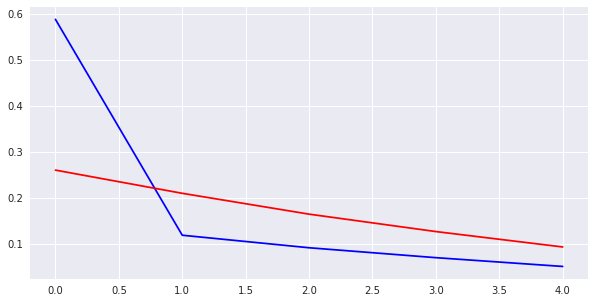

In [30]:
# PCA explained variance in each dimension
_, ax = plt.subplots(figsize = (10,5))
ax.plot(pca1.explained_variance_ratio_, color = 'b')
ax.plot(pca2.explained_variance_ratio_, color = 'r')

In [31]:
# We take the data frame with the data represented in the principal components
principalDf1 = pd.DataFrame(data = principalcomponents1, columns = ['1 - principal component {0}'.format(i+1) for i in range(5)])
principalDf2 = pd.DataFrame(data = principalcomponents2, columns = ['2 - principal component {0}'.format(i+1) for i in range(5)])

## Linear Regression

We fit a linear regression model for each case.

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
linreg1 = LinearRegression()
linreg2 = LinearRegression()

linreg1.fit(principalDf1, y)
linreg2.fit(principalDf2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
linreg1.coef_, linreg2.coef_

(array([-0.91965769,  0.07058203, -0.07954919, -0.08101775,  0.08261667]),
 array([-0.98416159,  1.0178017 , -0.98056836,  1.01863081,  0.99841066]))

The models acually fit our data very differently!

#### We now make prediction with each model and test the results.

In [35]:
df_test_1 = df_test.copy()
df_test_2 = df_test.copy()

y_test = df_test.y

df_test_2.drop('y', axis = 1, inplace = True)

In [36]:
principalcomponents_test_1 = pca1.transform(df_test_1)
principalcomponents_test_2 = pca2.transform(df_test_2) # Transforming our data with PCA

# Constructing our data frames.
principalDf1_test = pd.DataFrame(data = principalcomponents_test_1, columns = ['1 - principal component {0}'.format(i+1) for i in range(5)])
principalDf2_test = pd.DataFrame(data = principalcomponents_test_2, columns = ['2 - principal component {0}'.format(i+1) for i in range(5)])

predict_test_1 = linreg1.predict(principalDf1_test)
predict_test_2 = linreg2.predict(principalDf2_test) # Making our predicitions in each case

#### Final tests and metrics

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
e1 = mean_squared_error(predict_test_1, y_test)
e2 = mean_squared_error(predict_test_2, y_test)

e1, e2

(0.4556214294183669, 54.68698088102719)

Now, note:

In [41]:
r = 0
for i in range(5):
    r = r + np.std(df_test_2['Variable {0}'.format(i+1)])**2

In [42]:
r

54.8348126106643

The mean squared error of the second model approximates the sum of the variances of the features with least variance (which by the structure of our data, correspond to the first features). This means that error for the second model is exactly what we should expect, since we selected just 5 dimensions for the PCA, meaning that the features used to train the second models can't capture the smaller variance in the first features.

Now, we get a unexpectedly good result for the first model. This most likely means that the first features of the PCA encoded most of the information about the target variable since it has the largest variance. 